In [238]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import optuna
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, StackingRegressor, GradientBoostingRegressor
from tqdm import tqdm
import numpy as np
import joblib
import seaborn as sns
import os
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.optimize import minimize
import seaborn as sns
import optuna.visualization.matplotlib as optuna_vis
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor
import json

In [13]:
df = pd.read_csv('data_level_2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   kol_username                       671 non-null    object 
 1   month_start                        671 non-null    int64  
 2   year_start                         671 non-null    int64  
 3   month_end                          671 non-null    int64  
 4   year_end                           671 non-null    int64  
 5   total_posts_pr                     671 non-null    int64  
 6   total_posts_nonpr                  671 non-null    int64  
 7   unique_music_pr                    671 non-null    int64  
 8   unique_music_nonpr                 671 non-null    int64  
 9   ttSeller                           671 non-null    bool   
 10  commerceUser                       671 non-null    bool   
 11  emoji_count_pr                     671 non-null    int64  

In [242]:
df.describe()

,month_start,year_start,month_end,year_end,total_posts_pr,total_posts_nonpr,unique_music_pr,unique_music_nonpr,emoji_count_pr,emoji_count_nonpr,hashtag_count_pr,hashtag_count_nonpr,word_count_no_emoji_hashtag_pr,word_count_no_emoji_hashtag_nonpr,early_morning_pr,pr_ratio_early_morning,early_morning_nonpr,morning_pr,pr_ratio_morning,morning_nonpr,afternoon_pr,pr_ratio_afternoon,afternoon_nonpr,evening_pr,pr_ratio_evening,evening_nonpr,late_night_pr,pr_ratio_late_night,late_night_nonpr,is_weekend_pr,pr_ratio_weekend,is_weekend_nonpr,is_trending_pr,pr_ratio_trending,is_trending_nonpr,duration_pr,duration_nonpr,diggCount_pr,diggCount_nonpr,shareCount_pr,shareCount_nonpr,collectCount_pr,collectCount_nonpr,commentCount_pr,commentCount_nonpr,playCount_pr,playCount_nonpr,isSlideshow_pr,pr_ratio_slideshow,isSlideshow_nonpr,isSponsored_pr,pr_ratio_sponsored,isSponsored_nonpr,e_outlier_pr,pr_ratio_e_outlier,e_outlier_nonpr,follower_change_in_input_window,pr_engagement_rate_input,pr_post_ratio,female_percent,vietnam_follower,EngagementRateOnPRPost_target
count,671.000000,671.000000,671.00000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,6.710000e+02,6.710000e+02,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,6.710000e+02,6.710000e+02,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,466.000000,466.000000,671.000000
mean,6.146051,2024.092399,6.14307,2024.259314,13.764531,39.986587,12.149031,35.403875,8.606557,30.505216,64.157973,144.616990,213.731744,541.259314,0.070045,0.004083,0.736215,2.125186,0.120241,5.655738,3.560358,0.215309,11.976155,7.383010,0.573443,18.949329,0.625931,0.039233,2.669151,3.405365,0.229406,10.853949,2.535022,0.184310,7.229508,1102.807750,2492.499255,2.380532e+05,1.164796e+06,5708.667660,23867.296572,17087.861401,66234.590164,2791.627422,8158.056632,1.320081e+07,2.131546e+07,0.025335,0.005296,1.684054,0.453055,0.023609,0.214605,1.351714,0.075849,4.345753,28130.016393,0.019523,0.249329,80.311159,90.182403,0.023490
std,3.658090,0.289805,3.45769,0.438585,15.395909,22.997627,14.788110,19.513621,13.875896,29.854816,107.105341,170.254027,501.935534,403.773634,0.277806,0.018643,1.899061,4.421704,0.199262,6.748961,5.799550,0.229988,10.200353,8.670121,0.322360,12.177682,1.270274,0.085158,4.466885,4.173073,0.183082,6.918037,3.909599,0.214075,7.510257,1455.360851,1905.948515,4.743191e+05,1.829117e+06,15131.768015,37303.262511,35570.080212,97987.812290,7384.110979,10249.889415,1.933589e+07,2.734637e+07,0.175215,0.058264,3.380590,2.682244,0.097943,0.787113,1.896185,0.077546,3.455427,51384.536763,0.015265,0.215377,9.371873,7.567545,0.024709
min,1.000000,2024.000000,1.00000,2024.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000e+00,6.360000e+02,0.000000,5.000000,0.000000,34.000000,0.000000,10.000000,0.000000e+00,1.705800e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-20457.000000,0.000000,0.000000,48.000000,52.000000,0.000981
25%,3.000000,2024.000000,3.00000,2024.000000,4.000000,24.000000,4.000000,21.000000,1.000000,9.000000,12.000000,39.000000,48.500000,274.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,2.000000,0.333333,10.000000,0.000000,0.000000,0.000000,1.000000,0.100000,6.000000,0.000000,0.000000,2.000000,293.500000,1223.500000,2.849650e+04,1.707175e+05,421.000000,33

In [15]:
df.head()

,kol_username,month_start,year_start,month_end,year_end,total_posts_pr,total_posts_nonpr,unique_music_pr,unique_music_nonpr,ttSeller,...,isSponsored_nonpr,e_outlier_pr,pr_ratio_e_outlier,e_outlier_nonpr,follower_change_in_input_window,pr_engagement_rate_input,pr_post_ratio,female_percent,vietnam_follower,EngagementRateOnPRPost_target
0,hnhu2804,10,2024,12,2024,9,98,4,54,False,...,0,1,0.111111,10,0,0.025545,0.084112,90.0,95.0,0.027464
1,hnhu2804,11,2024,1,2025,16,113,7,62,False,...,0,1,0.062500,11,0,0.022451,0.124031,90.0,95.0,0.027832
2,hnhu2804,12,2024,2,2025,15,101,8,57,False,...,0,2,0.133333,5,0,0.028046,0.129310,90.0,95.0,0.004797
3,hnhu2804,1,2025,3,2025,13,107,6,53,False,...,0,2,0.153846,8,0,0.025166,0.108333,90.0,95.0,0.021435
4,dramakinglndx,1,2024,3,2024,1,11,1,10,False,...,0,0,0.000000,1,5702,0.050524,0.083333,78.0,90.0,0.021049


In [16]:
import numpy
print(numpy.__version__)


2.2.0


In [243]:
df.dtypes

kol_username                          object
month_start                            int64
year_start                             int64
month_end                              int64
year_end                               int64
total_posts_pr                         int64
total_posts_nonpr                      int64
unique_music_pr                        int64
unique_music_nonpr                     int64
ttSeller                                bool
commerceUser                            bool
emoji_count_pr                         int64
emoji_count_nonpr                      int64
hashtag_count_pr                       int64
hashtag_count_nonpr                    int64
word_count_no_emoji_hashtag_pr         int64
word_count_no_emoji_hashtag_nonpr      int64
early_morning_pr                       int64
pr_ratio_early_morning               float64
early_morning_nonpr                    int64
morning_pr                             int64
pr_ratio_morning                     float64
morning_no

# Hàm split train test không bị dataleakage

In [244]:
# Hàm lấy danh sách các tháng (dạng (year, month)) trong target
def get_target_months(row, buffer_months=1, target_duration=1):
    # Tính tháng bắt đầu target: month_end + buffer
    month = row['month_end'] + buffer_months
    year = row['year_end']

    # Điều chỉnh nếu tháng vượt quá 12
    if month > 12:
        month -= 12
        year += 1

    months = []
    for _ in range(target_duration):
        months.append((year, month))
        month += 1
        if month > 12:
            month = 1
            year += 1
    return set(months)

# Hàm chia train-test đúng theo logic KOL và target
def split_train_test(df):
    df = df.copy()

    # Tính target_months cho mỗi sample
    df['target_months'] = df.apply(get_target_months, axis=1)

    # Sắp xếp để lấy sample cuối cùng của mỗi KOL làm test
    df = df.sort_values(['kol_username', 'year_start', 'month_start'])
    test_samples = df.groupby('kol_username').tail(1)

    # Lưu mapping KOL → target_months trong test
    kol_to_test_targets = dict(zip(
        test_samples['kol_username'],
        test_samples['target_months']
    ))

    # Hàm kiểm tra xem sample có bị leak không (so với chính KOL đó)
    def is_leaked_sample(row):
        kol = row['kol_username']
        if kol not in kol_to_test_targets:
            return False
        return not row['target_months'].isdisjoint(kol_to_test_targets[kol])

    # Đánh dấu sample bị leak
    is_leak = df.apply(is_leaked_sample, axis=1)

    # Lọc lại: không lấy sample test, không lấy sample bị leak
    train_samples = df[~is_leak & ~df.index.isin(test_samples.index)]

    # Bỏ cột phụ
    return train_samples.drop(columns='target_months'), test_samples.drop(columns='target_months')

In [245]:
# Chia dữ liệu
train_full_df, test_df = split_train_test(df)

In [246]:
train_full_df.to_csv('full_train_set_lv2.csv', index=False)
test_df.to_csv('test_set_lv2.csv', index=False)


In [247]:
train_full_df.shape

(597, 65)

In [248]:
test_df.shape

(74, 65)

In [249]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 597 entries, 526 to 357
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   kol_username                       597 non-null    object 
 1   month_start                        597 non-null    int64  
 2   year_start                         597 non-null    int64  
 3   month_end                          597 non-null    int64  
 4   year_end                           597 non-null    int64  
 5   total_posts_pr                     597 non-null    int64  
 6   total_posts_nonpr                  597 non-null    int64  
 7   unique_music_pr                    597 non-null    int64  
 8   unique_music_nonpr                 597 non-null    int64  
 9   ttSeller                           597 non-null    bool   
 10  commerceUser                       597 non-null    bool   
 11  emoji_count_pr                     597 non-null    int64  
 1

In [250]:
test_df.head(20)

,kol_username,month_start,year_start,month_end,year_end,total_posts_pr,total_posts_nonpr,unique_music_pr,unique_music_nonpr,ttSeller,commerceUser,emoji_count_pr,emoji_count_nonpr,hashtag_count_pr,hashtag_count_nonpr,word_count_no_emoji_hashtag_pr,word_count_no_emoji_hashtag_nonpr,early_morning_pr,pr_ratio_early_morning,early_morning_nonpr,morning_pr,pr_ratio_morning,morning_nonpr,afternoon_pr,pr_ratio_afternoon,afternoon_nonpr,evening_pr,pr_ratio_evening,evening_nonpr,late_night_pr,pr_ratio_late_night,late_night_nonpr,is_weekend_pr,pr_ratio_weekend,is_weekend_nonpr,is_trending_pr,pr_ratio_trending,is_trending_nonpr,duration_pr,duration_nonpr,diggCount_pr,diggCount_nonpr,shareCount_pr,shareCount_nonpr,collectCount_pr,collectCount_nonpr,commentCount_pr,commentCount_nonpr,playCount_pr,playCount_nonpr,isSlideshow_pr,pr_ratio_slideshow,isSlideshow_nonpr,isSponsored_pr,pr_ratio_sponsored,isSponsored_nonpr,e_outlier_pr,pr_ratio_e_outlier,e_outlier_nonpr,follower_change_in_input_window,pr_engagement_rate_input,pr_post_ratio,female_percent,vietnam_follower,EngagementRateOnPRPost_target
529,_inlil,9,2024,11,2024,2,40,2,38,False,False,2,34,21,199,21,326,0,0.000000,0,0,0.000000,1,0,0.000000,2,2,1.000000,37,0,0.000000,0,2,1.000000,13,0,0.000000,13,204,1525,6093,1222912,80,11159,856,37625,53,5275,377400,23983800,0,0.000000,0,0,0.0,0,0,0.000000,6,95944,0.018765,0.047619,84.0,57.0,0.017258
621,actress.lanhuong,1,2025,3,2025,21,46,14,38,True,False,18,28,80,58,243,389,0,0.000000,0,1,0.047619,4,1,0.047619,36,19,0.904762,6,0,0.000000,0,2,0.095238,10,4,0.190476,1,1169,1195,104924,2545393,1365,66022,5379,180873,1433,10800,12133200,70267800,0,0.000000,0,0,0.0,0,2,0.095238,1,22939,0.009322,0.313433,NaN,NaN,0.012579
653,alissaho23,7,2024,9,2024,5,61,5,60,False,False,2,10,7,43,178,578,0,0.000000,0,0,0.000000,14,1,0.200000,14,4,0.800000,31,0,0.000000,2,0,0.000000,20,1,0.200000,1,626,2305,175900,1328254,5341,34121,10593,51916,1156,6686,8849000,18974800,0,0.000000,9,0,0.0,0,1,0.200000,5,18900,0.021809,0.075758,78.0,90.0,0.024808
128,beautytips4.0,1,2025,3,2025,60,5,59,5,False,False,60,3,487,43,1525,95,1,0.016667,0,0,0.000000,0,4,0.066667,0,55,0.916667,5,0,0.000000,0,14,0.233333,2,9,0.150000,2,5766,298,45866,10090,1437,523,3164,1103,1220,777,3582988,660866,0,0.000000,0,0,0.0,0,1,0.016667,1,-1560,0.014426,0.923077,NaN,NaN,0.015782
33,biveve131,1,2025,3,2025,0,11,0,11,False,False,0,5,0,79,0,88,0,0.000000,0,0,0.000000,3,0,0.000000,0,0,0.000000,8,0,0.000000,0,0,0.000000,5,0,0.000000,1,0,341,0,23652,0,827,0,3759,0,161,0,260736,0,0.000000,0,0,0.0,0,0,0.000000,1,9,0.000000,0.000000,NaN,NaN,0.009111
233,blingbabi_,1,2025,3,2025,3,44,3,39,False,False,3,52,9,61,36,384,0,0.000000,3,0,0.000000,5,3,1.000000,12,0,0.000000,17,0,0.000000,7,1,0.333333,14,0,0.000000,14,195,1739,5315,614846,156,19729,379,20985,47,3036,668800,10180200,0,0.000000,0,0,0.0,0,0,0.000000,6,28287,0.008817,0.063830,NaN,NaN,0.004281
167,bychloenguyen,1,2025,3,2025,9,33,9,33,False,False,11,48,44,173,118,408,0,0.000000,0,1,0.111111,3,1,0.111111,5,7,0.777778,22,0,0.000000,3,2,0.222222,9,0,0.000000,8,1042,3024,44564,600410,1626,23285,5692,33915,429,2558,5583600,10140900,0,0.000000,1,0,0.0,0,0,0.000000,2,4779,0.009369,0.214286,86.0,89.0,0.005564
220,bylinhtruong,1,2025,3,2025,1,20,1,19,False,True,0,3,3,16,7,388,0,0.000000,0,0,0.000000,6,0,0.000000,8,1,1.000000,6,0,0.000000,0,0,0.000000,3,0,0.000000,3,98,2130,20100,31917,38,337,216,1490,1,308,562000,524386,0,0.000000,0,0,0.0,0,0,0.000000,3,317,0.036219,0.047619,74.0,94.0,0.014736
397,chaubui,11,2024,1,2025,4,36,4,36,False,False,7,36,14,61,57,552,0,0.000000,0,2,0.500000,2,1,0.250000,8,1,0.250000,19,0,0.000000,7,1,0.250000,9,1,0.250000,11,384,1827,66382,871992,598,16958,2299,13915,299,10166,12367900,29791800,0,0.000000,1,0,0.0,0,0,0.000000,3,8652,0.005626,0.100000,NaN,NaN,0.015141
140,chouchinchan,1,2025,3,2025,41,45,41,45,True,True,17,24,113,109,487,574,0,0.000000,0,0,0.000000,6,23,0.560976,23,17,0.414634,16,1,0.024390,0,10,0.243902,13,3,0.073171,5,9193,820

In [251]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 597 entries, 526 to 357
Data columns (total 65 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   kol_username                       597 non-null    object 
 1   month_start                        597 non-null    int64  
 2   year_start                         597 non-null    int64  
 3   month_end                          597 non-null    int64  
 4   year_end                           597 non-null    int64  
 5   total_posts_pr                     597 non-null    int64  
 6   total_posts_nonpr                  597 non-null    int64  
 7   unique_music_pr                    597 non-null    int64  
 8   unique_music_nonpr                 597 non-null    int64  
 9   ttSeller                           597 non-null    bool   
 10  commerceUser                       597 non-null    bool   
 11  emoji_count_pr                     597 non-null    int64  
 1

In [30]:
earliest_sample_per_kol = train_full_df.groupby('kol_username')[['year_start', 'month_start']].min().reset_index()

# Hiển thị kết quả
print("Thông tin tháng bắt đầu sớm nhất của mỗi KOL:")
# Hiển thị tất cả các hàng (không giới hạn)
pd.set_option('display.max_rows', None)

# Hiển thị tất cả các cột (không giới hạn)
pd.set_option('display.max_columns', None)

# Hiển thị toàn bộ nội dung của ô, không cắt ngắn
pd.set_option('display.max_colwidth', None)

# Bây giờ bạn có thể hiển thị DataFrame của mình
print(earliest_sample_per_kol)

Thông tin tháng bắt đầu sớm nhất của mỗi KOL:
           kol_username  year_start  month_start
0                _inlil        2024            4
1      actress.lanhuong        2024            1
2            alissaho23        2024            3
3         beautytips4.0        2024            2
4             biveve131        2024            7
5            blingbabi_        2024            1
6         bychloenguyen        2024            1
7          bylinhtruong        2024            1
8               chaubui        2024            1
9          chouchinchan        2024            1
10            conkien01        2024            1
11       dangvbeauty179        2024            1
12           dieplamanh        2024            1
13         dieplinhcami        2024            1
14        dramakinglndx        2024            1
15    drkhonghanhnguyen        2024            2
16             eb06thg9        2024            1
17    emma1010_official        2024            1
18        gigigithebabe

# Feature Selection

In [31]:
# Đảm bảo các cột dạng categorical được chuyển sang đúng kiểu
categorical_features = ['ttSeller', 'commerceUser']  # thêm các cột categorical bạn có

for col in categorical_features:
    train_full_df[col] = train_full_df[col].astype("category")

In [32]:
target_col = 'EngagementRateOnPRPost_target'

# Loại bỏ các cột không dùng
drop_cols = ['kol_username', target_col]
X = train_full_df.drop(columns=drop_cols)
y = train_full_df[target_col]

# === Tạo Dataset LightGBM ===
lgb_train = lgb.Dataset(X, label=y, categorical_feature=categorical_features, free_raw_data=False)

# === Train nhanh mô hình LightGBM để lấy feature importance ===
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
}

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100  # chỉ train nhanh thôi để lấy importance
)

## Feature importance ( gain ) of LightGBM model

In [ ]:
# === Tính Feature Importance theo 'gain' ===
importance_df = pd.DataFrame({
    'feature': model.feature_name(),
    'importance_gain': model.feature_importance(importance_type='gain')
}).sort_values(by='importance_gain', ascending=False)

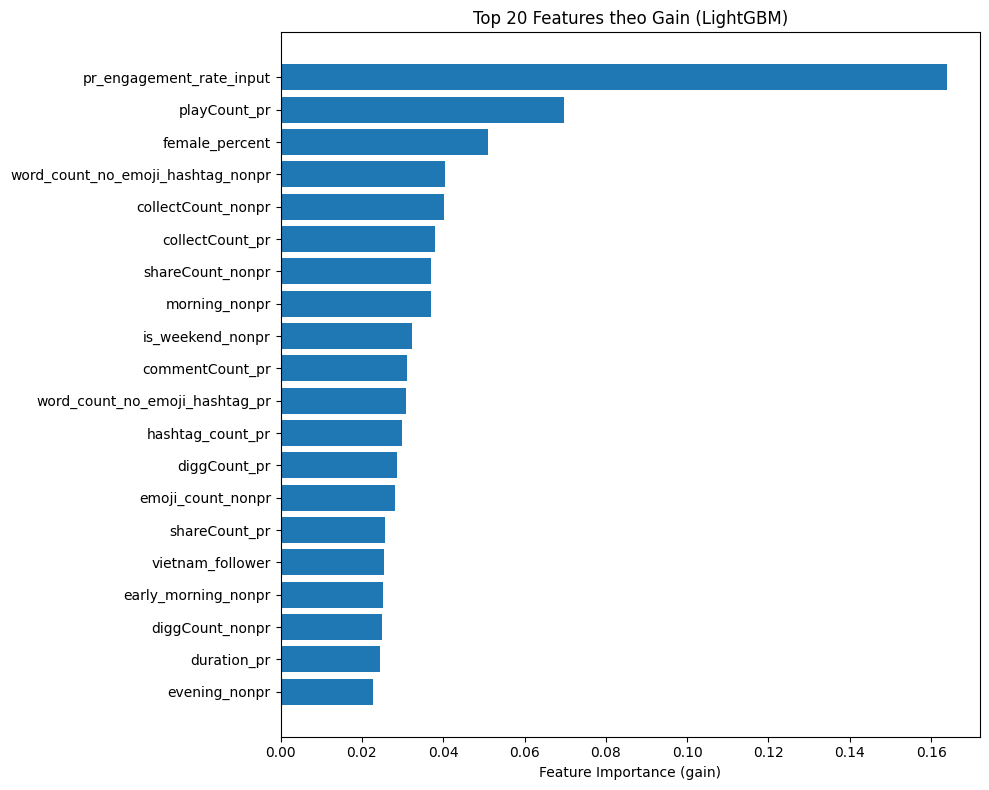

                              feature  importance_gain
59           pr_engagement_rate_input         0.163832
47                       playCount_pr         0.069737
61                     female_percent         0.050905
15  word_count_no_emoji_hashtag_nonpr         0.040537
44                 collectCount_nonpr         0.040301
43                    collectCount_pr         0.038097
42                   shareCount_nonpr         0.037106
21                      morning_nonpr         0.036872
33                   is_weekend_nonpr         0.032379
45                    commentCount_pr         0.031161
14     word_count_no_emoji_hashtag_pr         0.030827
12                   hashtag_count_pr         0.029824
39                       diggCount_pr         0.028655
11                  emoji_count_nonpr         0.028193
41                      shareCount_pr         0.025566
62                   vietnam_follower         0.025486
18                early_morning_nonpr         0.025227
40        

In [34]:
# === Hiển thị top 20 feature quan trọng nhất ===
plt.figure(figsize=(10, 8))
top_n = 20
plt.barh(importance_df['feature'][:top_n][::-1], importance_df['importance_gain'][:top_n][::-1])
plt.xlabel("Feature Importance (gain)")
plt.title("Top 20 Features theo Gain (LightGBM)")
plt.tight_layout()
plt.show()

# in bảng
print(importance_df.head(30))

## Shap

In [35]:
# Giả sử model là mô hình LightGBM đã huấn luyện
explainer = shap.TreeExplainer(model)

# Tính SHAP values cho tập train (hoặc validation)
shap_values = explainer.shap_values(X)

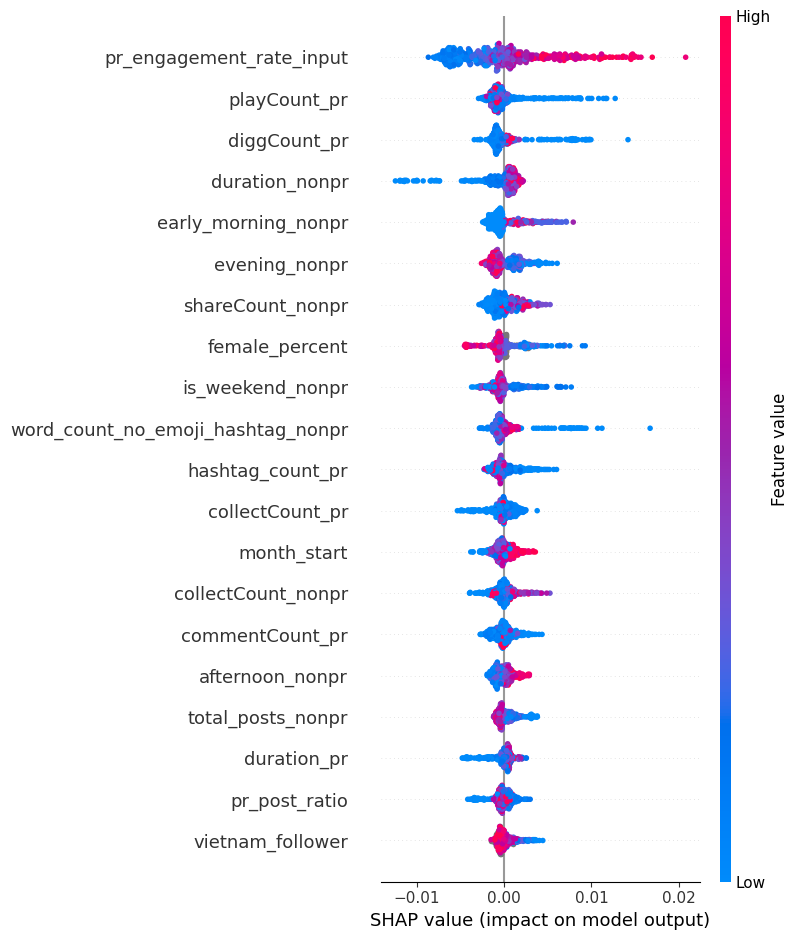

In [36]:
shap.summary_plot(shap_values, X)

## Permutation Importance

In [37]:
# Gán lại X và y để giữ nguyên cột 'kol_username' (đã bị drop trong bước trước)
X_full = train_full_df.drop(columns=[target_col])
y = train_full_df[target_col]

# Dữ liệu mô hình không có kol_username
X_model = X_full.drop(columns=['kol_username'])

# === Tính baseline RMSE ===
baseline_preds = model.predict(X_model)
baseline_rmse = np.sqrt(mean_squared_error(y, baseline_preds))

# === Tính Permutation Importance (shuffle giữa các KOL) ===
perm_results = []
feature_names = X_model.columns.tolist()

for feature in tqdm(feature_names):
    X_shuffled = X_model.copy()

    # Shuffle giá trị của feature này giữa các KOL khác nhau
    shuffled_col = []
    for kol in X_full['kol_username'].unique():
        mask = X_full['kol_username'] != kol  # lấy dữ liệu của các KOL khác
        available_vals = X_full.loc[mask, feature].values
        kol_size = (X_full['kol_username'] == kol).sum()
        shuffled_vals = np.random.choice(available_vals, size=kol_size, replace=True)
        shuffled_col.append(shuffled_vals)

    X_shuffled[feature] = np.concatenate(shuffled_col)

    if feature in categorical_features:
        # Khôi phục lại dtype category và categories ban đầu
        X_shuffled[feature] = pd.Categorical(
            X_shuffled[feature],
            categories=X_model[feature].cat.categories
        )

    # Dự đoán lại
    y_pred_shuffled = model.predict(X_shuffled)
    rmse_shuffled = np.sqrt(mean_squared_error(y, y_pred_shuffled))
    
    importance = rmse_shuffled - baseline_rmse
    perm_results.append((feature, importance))

100%|██████████| 63/63 [00:03<00:00, 18.12it/s]


In [38]:
# Chuyển sang DataFrame và sắp xếp
perm_df = pd.DataFrame(perm_results, columns=["feature", "perm_importance"])
perm_df = perm_df.sort_values(by="perm_importance", ascending=False)

# In ra top 30 feature
print(perm_df.head(30))

                              feature  perm_importance
59           pr_engagement_rate_input         0.004864
61                     female_percent         0.001854
39                       diggCount_pr         0.001553
47                       playCount_pr         0.001453
15  word_count_no_emoji_hashtag_nonpr         0.001360
38                     duration_nonpr         0.001339
27                      evening_nonpr         0.001316
33                   is_weekend_nonpr         0.001245
18                early_morning_nonpr         0.001212
42                   shareCount_nonpr         0.001064
12                   hashtag_count_pr         0.001063
2                           month_end         0.000852
43                    collectCount_pr         0.000848
40                    diggCount_nonpr         0.000793
44                 collectCount_nonpr         0.000770
45                    commentCount_pr         0.000762
21                      morning_nonpr         0.000673
60        

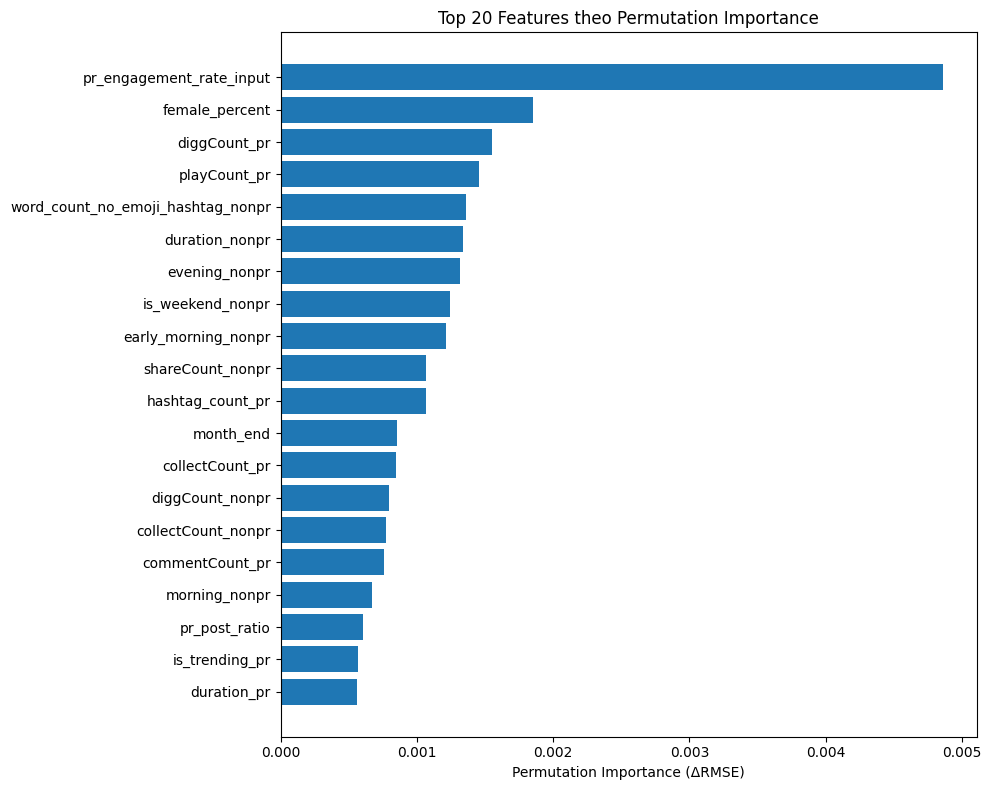

In [39]:
# Chọn số lượng feature hiển thị
top_n = 20
top_features = perm_df.head(top_n)

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
plt.barh(top_features["feature"][::-1], top_features["perm_importance"][::-1])
plt.xlabel("Permutation Importance (ΔRMSE)")
plt.title(f"Top {top_n} Features theo Permutation Importance")
plt.tight_layout()
plt.show()

In [40]:
# 1. === Feature Importance by Gain ===
top_gain = importance_df.sort_values(by='importance_gain', ascending=False).head(15)
gain_features = set(top_gain['feature'])

# 2. === SHAP ===
shap_abs_mean = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': shap_abs_mean
}).sort_values(by='mean_abs_shap', ascending=False)
shap_features = set(shap_df.head(15)['feature'])

# 3. === Permutation Importance ===
top_perm = perm_df.sort_values(by='perm_importance', ascending=False).head(15)
perm_features = set(top_perm['feature'])

# === Union: giữ tất cả các feature xuất hiện trong ít nhất 1 phương pháp
final_features = list(gain_features | shap_features | perm_features)

# In ra kết quả
print("✅ Final selected features (xuất hiện trong ít nhất 1 phương pháp):")
print(final_features)

✅ Final selected features (xuất hiện trong ít nhất 1 phương pháp):
['evening_nonpr', 'is_weekend_nonpr', 'month_start', 'female_percent', 'word_count_no_emoji_hashtag_nonpr', 'word_count_no_emoji_hashtag_pr', 'playCount_pr', 'pr_engagement_rate_input', 'collectCount_pr', 'month_end', 'shareCount_nonpr', 'hashtag_count_pr', 'emoji_count_nonpr', 'collectCount_nonpr', 'early_morning_nonpr', 'morning_nonpr', 'duration_nonpr', 'shareCount_pr', 'diggCount_pr', 'diggCount_nonpr', 'commentCount_pr']


In [252]:
final_features

['evening_nonpr',
 'is_weekend_nonpr',
 'month_start',
 'female_percent',
 'word_count_no_emoji_hashtag_nonpr',
 'word_count_no_emoji_hashtag_pr',
 'playCount_pr',
 'pr_engagement_rate_input',
 'collectCount_pr',
 'month_end',
 'shareCount_nonpr',
 'hashtag_count_pr',
 'emoji_count_nonpr',
 'collectCount_nonpr',
 'early_morning_nonpr',
 'morning_nonpr',
 'duration_nonpr',
 'shareCount_pr',
 'diggCount_pr',
 'diggCount_nonpr',
 'commentCount_pr']

In [253]:
len(final_features)

21

---
# Training models

đánh giá trên các models sau đây:

- Mean Predictor

- Linear Model: Linear Regression, Ridge Regression, Lasso Regression, Support Vector Regression.

- Tree-based Model: RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, XGBoost, LightGBM, CatBoost.


In [254]:
len(list(train_full_df.columns))

65

In [ ]:
train_local_df, dev_df = split_train_test(train_full_df)
# Xác định các cột cần giữ lại
cols_to_keep = final_features + ['EngagementRateOnPRPost_target']

if 'kol_username' in train_full_df.columns:
    cols_to_keep.append('kol_username')

# Gán lại để thay đổi trực tiếp
train_full_df = train_full_df[cols_to_keep].copy()
train_local_df = train_local_df[cols_to_keep].copy()
dev_df = dev_df[cols_to_keep].copy()
test_df = test_df[cols_to_keep].copy()

In [45]:
train_local_df.to_csv('sub_train_set_lv2.csv', index=False)
dev_df.to_csv('dev_set_lv2.csv', index=False)

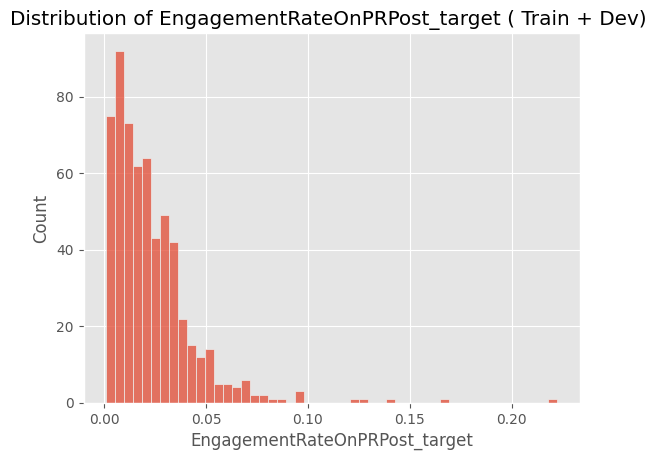

In [124]:
sns.histplot(train_full_df['EngagementRateOnPRPost_target'], bins=50)
plt.title("Distribution of EngagementRateOnPRPost_target ( Train + Dev) ")
plt.show()

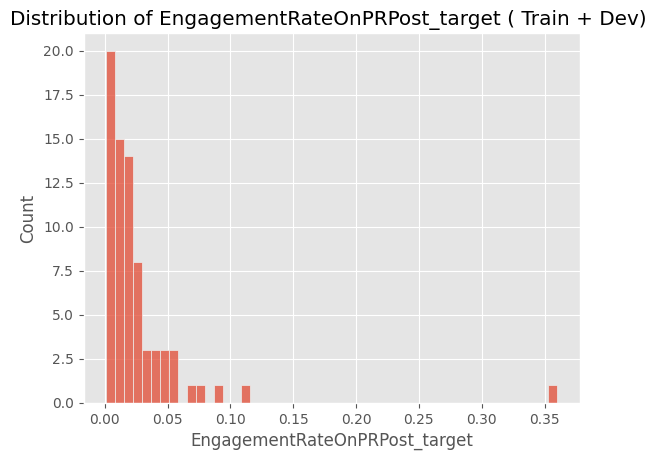

In [232]:
sns.histplot(test_df['EngagementRateOnPRPost_target'], bins=50)
plt.title("Distribution of EngagementRateOnPRPost_target ( Train + Dev) ")
plt.show()

In [256]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 597 entries, 526 to 357
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   evening_nonpr                      597 non-null    int64  
 1   is_weekend_nonpr                   597 non-null    int64  
 2   month_start                        597 non-null    int64  
 3   female_percent                     415 non-null    float64
 4   word_count_no_emoji_hashtag_nonpr  597 non-null    int64  
 5   word_count_no_emoji_hashtag_pr     597 non-null    int64  
 6   playCount_pr                       597 non-null    int64  
 7   pr_engagement_rate_input           597 non-null    float64
 8   collectCount_pr                    597 non-null    int64  
 9   month_end                          597 non-null    int64  
 10  shareCount_nonpr                   597 non-null    int64  
 11  hashtag_count_pr                   597 non-null    int64  
 1

In [257]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 597 entries, 526 to 357
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   evening_nonpr                      597 non-null    int64  
 1   is_weekend_nonpr                   597 non-null    int64  
 2   month_start                        597 non-null    int64  
 3   female_percent                     415 non-null    float64
 4   word_count_no_emoji_hashtag_nonpr  597 non-null    int64  
 5   word_count_no_emoji_hashtag_pr     597 non-null    int64  
 6   playCount_pr                       597 non-null    int64  
 7   pr_engagement_rate_input           597 non-null    float64
 8   collectCount_pr                    597 non-null    int64  
 9   month_end                          597 non-null    int64  
 10  shareCount_nonpr                   597 non-null    int64  
 11  hashtag_count_pr                   597 non-null    int64  
 1

---

# Version 2

In [258]:
train_full_df = pd.read_csv('full_train_set_lv2.csv')

cols_to_keep = final_features + ['EngagementRateOnPRPost_target']
if 'kol_username' in train_full_df.columns:
    cols_to_keep.append('kol_username')
    
train_full_df = train_full_df[cols_to_keep].copy()

train_local_df = pd.read_csv('sub_train_set_lv2.csv')

dev_df = pd.read_csv('dev_set_lv2.csv')

test_df = pd.read_csv('test_set_lv2.csv')
test_df = test_df[cols_to_keep].copy()

In [259]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   evening_nonpr                      597 non-null    int64  
 1   is_weekend_nonpr                   597 non-null    int64  
 2   month_start                        597 non-null    int64  
 3   female_percent                     415 non-null    float64
 4   word_count_no_emoji_hashtag_nonpr  597 non-null    int64  
 5   word_count_no_emoji_hashtag_pr     597 non-null    int64  
 6   playCount_pr                       597 non-null    int64  
 7   pr_engagement_rate_input           597 non-null    float64
 8   collectCount_pr                    597 non-null    int64  
 9   month_end                          597 non-null    int64  
 10  shareCount_nonpr                   597 non-null    int64  
 11  hashtag_count_pr                   597 non-null    int64  

In [260]:
train_local_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   evening_nonpr                      528 non-null    int64  
 1   is_weekend_nonpr                   528 non-null    int64  
 2   month_start                        528 non-null    int64  
 3   female_percent                     367 non-null    float64
 4   word_count_no_emoji_hashtag_nonpr  528 non-null    int64  
 5   word_count_no_emoji_hashtag_pr     528 non-null    int64  
 6   playCount_pr                       528 non-null    int64  
 7   pr_engagement_rate_input           528 non-null    float64
 8   collectCount_pr                    528 non-null    int64  
 9   month_end                          528 non-null    int64  
 10  shareCount_nonpr                   528 non-null    int64  
 11  hashtag_count_pr                   528 non-null    int64  

In [261]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   evening_nonpr                      69 non-null     int64  
 1   is_weekend_nonpr                   69 non-null     int64  
 2   month_start                        69 non-null     int64  
 3   female_percent                     48 non-null     float64
 4   word_count_no_emoji_hashtag_nonpr  69 non-null     int64  
 5   word_count_no_emoji_hashtag_pr     69 non-null     int64  
 6   playCount_pr                       69 non-null     int64  
 7   pr_engagement_rate_input           69 non-null     float64
 8   collectCount_pr                    69 non-null     int64  
 9   month_end                          69 non-null     int64  
 10  shareCount_nonpr                   69 non-null     int64  
 11  hashtag_count_pr                   69 non-null     int64  
 

In [262]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   evening_nonpr                      74 non-null     int64  
 1   is_weekend_nonpr                   74 non-null     int64  
 2   month_start                        74 non-null     int64  
 3   female_percent                     51 non-null     float64
 4   word_count_no_emoji_hashtag_nonpr  74 non-null     int64  
 5   word_count_no_emoji_hashtag_pr     74 non-null     int64  
 6   playCount_pr                       74 non-null     int64  
 7   pr_engagement_rate_input           74 non-null     float64
 8   collectCount_pr                    74 non-null     int64  
 9   month_end                          74 non-null     int64  
 10  shareCount_nonpr                   74 non-null     int64  
 11  hashtag_count_pr                   74 non-null     int64  
 

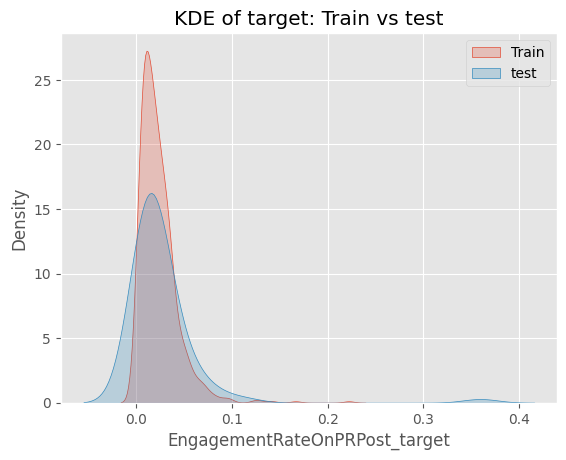

In [147]:
sns.kdeplot(train_full_df["EngagementRateOnPRPost_target"], label="Train", fill=True)
sns.kdeplot(test_df["EngagementRateOnPRPost_target"], label="test", fill=True)
plt.title("KDE of target: Train vs test")
plt.legend()
plt.show()

In [263]:
# ========= Dữ liệu =========
drop_columns = ["vietnam_follower", "female_percent", "kol_username"]
X_train = train_local_df[final_features].drop(columns=drop_columns, errors="ignore")
y_train = train_local_df['EngagementRateOnPRPost_target']
X_val = dev_df[final_features].drop(columns=drop_columns, errors="ignore")
y_val = dev_df['EngagementRateOnPRPost_target']

# ========= Huấn luyện lại trên toàn bộ train_full_df =========
X_full = train_full_df[final_features].drop(columns=drop_columns, errors="ignore")
y_full = train_full_df['EngagementRateOnPRPost_target']

# === Dữ liệu test ===
X_test = test_df[final_features].drop(columns=drop_columns, errors="ignore")
y_test = test_df['EngagementRateOnPRPost_target']  # giữ nguyên scale gốc

In [234]:
def evaluate_model(model, X_test, y_test_original):
    y_pred = model.predict(X_test)
    y_test = y_test_original

    # ✅ Thêm RMSLE
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mean_target = y_test.mean()
    
    print('y_test: ',y_test)
    print('y_pred: ',y_pred)

    print("📊 Đánh giá mô hình:")
    print(f"RMSLE: {rmsle:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Mean target: {mean_target:.4f}")
    print(f"MAE / mean target: {mae / mean_target:.2%}")
    
    return y_pred


## Mean Predictor

In [181]:
# Giả sử bạn đã có y_full (log-transform) và y_test (scale gốc)

# 1. Tính toán giá trị dự đoán
mean_target_original_scale = y_full.mean()
y_pred_mean = np.full(y_test.shape[0], mean_target_original_scale)

# 2. Tính toán và in các chỉ số
print("================== Mean Predictor ==================")
# RMSLE
rmsle_mean = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred_mean)))

# RMSE
rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_mean))

# R²
r2_mean = r2_score(y_test, y_pred_mean)

# MAE
mae_mean = mean_absolute_error(y_test, y_pred_mean)

# Mean target và MAE / Mean target
mean_target = y_test.mean()
mae_percentage = mae_mean / mean_target

print("📊 Đánh giá mô hình Mean Predictor:")
print(f"RMSLE: {rmsle_mean:.4f}")
print(f"RMSE: {rmse_mean:.4f}")
print(f"R²: {r2_mean:.4f}")
print(f"MAE: {mae_mean:.4f}")
print(f"Mean target: {mean_target:.4f}")
print(f"MAE / mean target: {mae_percentage:.2%}")

================== Mean Predictor ==================
📊 Đánh giá mô hình Mean Predictor:
RMSLE: 0.0387
RMSE: 0.0444
R²: -0.0070
MAE: 0.0196
Mean target: 0.0268
MAE / mean target: 73.14%


## Random Forest

In [182]:
X_train.columns

Index(['evening_nonpr', 'is_weekend_nonpr', 'month_start',
       'word_count_no_emoji_hashtag_nonpr', 'word_count_no_emoji_hashtag_pr',
       'playCount_pr', 'pr_engagement_rate_input', 'collectCount_pr',
       'month_end', 'shareCount_nonpr', 'hashtag_count_pr',
       'emoji_count_nonpr', 'collectCount_nonpr', 'early_morning_nonpr',
       'morning_nonpr', 'duration_nonpr', 'shareCount_pr', 'diggCount_pr',
       'diggCount_nonpr', 'commentCount_pr'],
      dtype='object')

In [183]:
# ========= Tối ưu với Optuna =========
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    rf_model = RandomForestRegressor(**params)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)
    y_true = y_val 

    # ✅ Tính RMSLE trên scale gốc, bằng cách log lại trước khi tính sai số
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
    return rmsle

study = optuna.create_study(direction='minimize')
study.optimize(objective_rf, n_trials=100)

# ========= Kết quả =========
rf_best_params_v2 = study.best_trial.params
print("✅ Best params:", rf_best_params_v2)

os.makedirs("model_version_2", exist_ok=True)
# ========= Lưu các siêu tham số tốt nhất vào file JSON =========
params_path = "./model_version_2/rf_best_params_v2.json"
with open(params_path, 'w') as f:
    json.dump(rf_best_params_v2, f, indent=4)
print(f"✅ Đã lưu siêu tham số tại {params_path}")



rf_model_optuna_v2 = RandomForestRegressor(**rf_best_params_v2, random_state=42)
rf_model_optuna_v2.fit(X_full, y_full)

# ========= Lưu lại =========
model_path = "./model_version_2/rf_model_optuna_v2.pkl"
joblib.dump(rf_model_optuna_v2, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")

[I 2025-08-22 16:49:56,931] A new study created in memory with name: no-name-ae9b275a-eae8-4381-ac19-393ede1093dd
[I 2025-08-22 16:49:57,818] Trial 0 finished with value: 0.023608723527616157 and parameters: {'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.023608723527616157.
[I 2025-08-22 16:49:58,179] Trial 1 finished with value: 0.02333274870097639 and parameters: {'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.02333274870097639.
[I 2025-08-22 16:49:58,508] Trial 2 finished with value: 0.023332748700976392 and parameters: {'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.02333274870097639.
[I 2025-08-22 16:49:58,962] Trial 3 finished with value: 0.02349817

✅ Best params: {'n_estimators': 200, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
✅ Đã lưu siêu tham số tại ./model_version_2/rf_best_params_v2.json
✅ Đã lưu mô hình tại ./model_version_2/rf_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_36863/2680660430.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study)


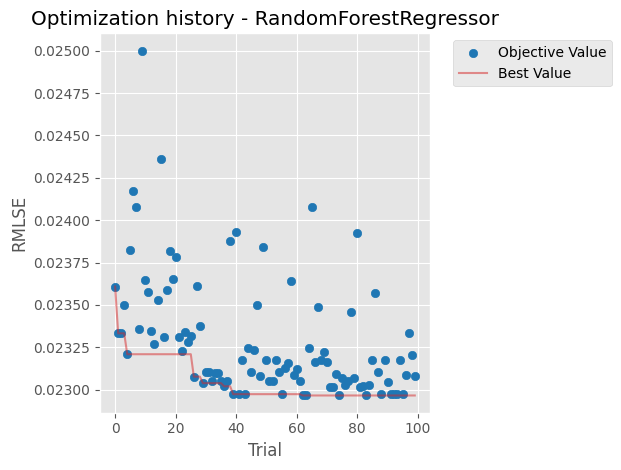

In [184]:
optuna_vis.plot_optimization_history(study)
plt.title("Optimization history - RandomForestRegressor")
plt.xlabel("Trial")
plt.ylabel("RMLSE")
plt.tight_layout()
plt.show()

In [185]:
y_pred_test = evaluate_model(rf_model_optuna_v2, X_test, y_test)

📊 Đánh giá mô hình:
RMSLE: 0.0392
RMSE: 0.0449
R²: -0.0291
MAE: 0.0199
Mean target: 0.0268
MAE / mean target: 74.15%


## ExtraTreesRegressor

In [186]:
# ========= Tối ưu với Optuna =========
def objective_et(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    et_model = ExtraTreesRegressor(**params)
    et_model.fit(X_train, y_train)

    # Dự đoán và đảo log
    y_pred = et_model.predict(X_val)
    y_true = y_val

    # ✅ Sửa: Tính RMSLE thay vì RMSE
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
    return rmsle

# ========= Tối ưu Optuna =========
study_et = optuna.create_study(direction='minimize', study_name="ExtraTrees_RMSLE_v2")
study_et.optimize(objective_et, n_trials=100)

# ========= Kết quả =========
et_best_params_v2 = study_et.best_trial.params
print("✅ Best params (ExtraTrees v2):", et_best_params_v2)

# ========= Lưu các siêu tham số tốt nhất vào file JSON =========
os.makedirs("model_version_2", exist_ok=True)
params_path = "./model_version_2/et_best_params_v2.json"
with open(params_path, 'w') as f:
    json.dump(et_best_params_v2, f, indent=4)
print(f"✅ Đã lưu siêu tham số tại {params_path}")

# ========= Huấn luyện lại trên toàn bộ train_full_df =========

et_model_optuna_v2 = ExtraTreesRegressor(**et_best_params_v2, random_state=42)
et_model_optuna_v2.fit(X_full, y_full)

# ========= Lưu lại =========
model_path = "./model_version_2/et_model_optuna_v2.pkl"
joblib.dump(et_model_optuna_v2, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")

[I 2025-08-22 16:54:10,614] A new study created in memory with name: ExtraTrees_RMSLE_v2
[I 2025-08-22 16:54:11,836] Trial 0 finished with value: 0.0217019224857897 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.0217019224857897.
[I 2025-08-22 16:54:12,711] Trial 1 finished with value: 0.0217601260361967 and parameters: {'n_estimators': 250, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.0217019224857897.
[I 2025-08-22 16:54:13,167] Trial 2 finished with value: 0.021608874094142215 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 0.021608874094142215.
[I 2025-08-22 16:54:13,461] Trial 3 finished with value: 0.02181518307422277 and parameters: {'n_

✅ Best params (ExtraTrees v2): {'n_estimators': 50, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}
✅ Đã lưu siêu tham số tại ./model_version_2/et_best_params_v2.json
✅ Đã lưu mô hình tại ./model_version_2/et_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_36863/2652969970.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_et)


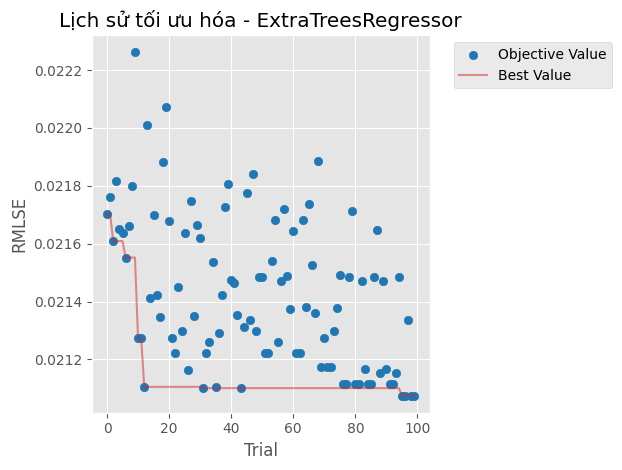

In [187]:
optuna_vis.plot_optimization_history(study_et)
plt.title("Lịch sử tối ưu hóa - ExtraTreesRegressor")
plt.xlabel("Trial")
plt.ylabel("RMLSE")
plt.tight_layout()
plt.show()

In [233]:
# === Dữ liệu test ===
y_pred_test = evaluate_model(et_model_optuna_v2, X_test, y_test)

📊 Đánh giá mô hình:
RMSLE: 0.0387
RMSE: 0.0444
R²: -0.0085
MAE: 0.0195
Mean target: 0.0268
MAE / mean target: 72.66%


## HistGradientBoostingRegressor

In [189]:
# ========= Tối ưu với Optuna (theo RMSE) =========
def objective_hgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'max_iter': trial.suggest_int('max_iter', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 40),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-3, 1.0, log=True),
        'early_stopping': False,
        'random_state': 42
    }

    hgb_model = HistGradientBoostingRegressor(**params)
    hgb_model.fit(X_train, y_train)

    y_pred = hgb_model.predict(X_val)
    y_true = y_val

    # ✅ Sửa: Tính RMSLE thay vì RMSE
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
    return rmsle

# ========= Thực hiện tối ưu =========
study_hgb = optuna.create_study(direction='minimize', study_name="HistGradientBoosting_RMLSE")
study_hgb.optimize(objective_hgb, n_trials=100)

# ========= Kết quả =========
hgb_best_params_v2 = study_hgb.best_trial.params
print("✅ Best params (HistGradientBoosting, RMLSE):", hgb_best_params_v2)

# ========= Lưu các siêu tham số tốt nhất vào file JSON =========
os.makedirs("model_version_2", exist_ok=True)
params_path = "./model_version_2/hgb_best_params_v2.json"
with open(params_path, 'w') as f:
    json.dump(hgb_best_params_v2, f, indent=4)
print(f"✅ Đã lưu siêu tham số tại {params_path}")

# ========= Huấn luyện lại trên toàn bộ train_full_df =========

hgb_model_optuna_v2 = HistGradientBoostingRegressor(**hgb_best_params_v2, random_state=42)
hgb_model_optuna_v2.fit(X_full, y_full)

# ========= Lưu lại =========
model_path = "./model_version_2/hgb_model_optuna_v2.pkl"
joblib.dump(hgb_model_optuna_v2, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")

[I 2025-08-22 17:12:17,876] A new study created in memory with name: HistGradientBoosting_RMLSE
[I 2025-08-22 17:12:19,268] Trial 0 finished with value: 0.026485771309078678 and parameters: {'learning_rate': 0.06771842318323215, 'max_iter': 500, 'max_depth': 4, 'min_samples_leaf': 13, 'l2_regularization': 0.35208966560190724}. Best is trial 0 with value: 0.026485771309078678.
[I 2025-08-22 17:12:19,512] Trial 1 finished with value: 0.023863380101279752 and parameters: {'learning_rate': 0.04234477693881486, 'max_iter': 250, 'max_depth': 3, 'min_samples_leaf': 28, 'l2_regularization': 0.34770255492301827}. Best is trial 1 with value: 0.023863380101279752.
[I 2025-08-22 17:12:19,682] Trial 2 finished with value: 0.02217294975204912 and parameters: {'learning_rate': 0.024024974533926578, 'max_iter': 100, 'max_depth': 9, 'min_samples_leaf': 38, 'l2_regularization': 0.00673737437317987}. Best is trial 2 with value: 0.02217294975204912.
[I 2025-08-22 17:12:19,931] Trial 3 finished with value:

✅ Best params (HistGradientBoosting, RMLSE): {'learning_rate': 0.014769541869488886, 'max_iter': 100, 'max_depth': 9, 'min_samples_leaf': 38, 'l2_regularization': 0.27369319103898665}
✅ Đã lưu siêu tham số tại ./model_version_2/hgb_best_params_v2.json
✅ Đã lưu mô hình tại ./model_version_2/hgb_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_36863/3841899641.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_hgb)


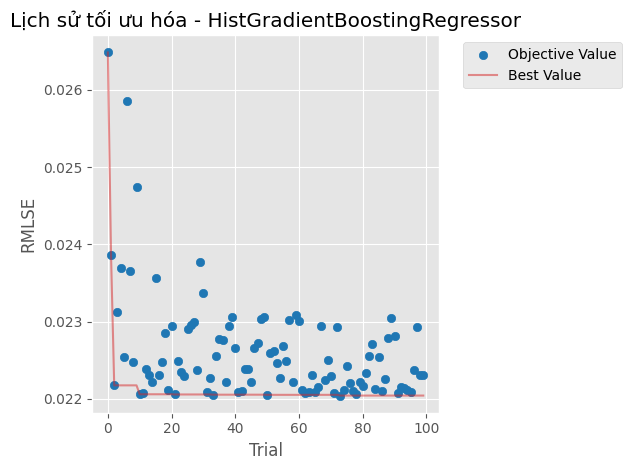

In [190]:
optuna_vis.plot_optimization_history(study_hgb)
plt.title("Lịch sử tối ưu hóa - HistGradientBoostingRegressor")
plt.xlabel("Trial")
plt.ylabel("RMLSE")
plt.tight_layout()
plt.show()

In [191]:
y_pred_test = evaluate_model(hgb_model_optuna_v2, X_test, y_test)

📊 Đánh giá mô hình:
RMSLE: 0.0388
RMSE: 0.0445
R²: -0.0129
MAE: 0.0194
Mean target: 0.0268
MAE / mean target: 72.50%


## XGboost

In [192]:
# ========= Tối ưu với Optuna (theo RMSE) =========
def objective_xgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),             
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),           
        'max_depth': trial.suggest_int('max_depth', 3, 10),                             
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 3),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
        'objective': 'reg:squarederror'
    }

    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_val)
    y_true = y_val

    # ✅ Sửa: Tính RMSLE thay vì RMSE
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
    return rmsle

# ========= Thực hiện tối ưu =========
study_xgb = optuna.create_study(direction='minimize', study_name="XGBoost_RMSLE_v2")
study_xgb.optimize(objective_xgb, n_trials=100)

# ========= Kết quả =========
xgb_best_params_v2 = study_xgb.best_trial.params
print("✅ Best params (XGBoost, RMSLE):", xgb_best_params_v2)

# ========= Lưu các siêu tham số tốt nhất vào file JSON =========
os.makedirs("model_version_2", exist_ok=True)
params_path = "./model_version_2/xgb_best_params_v2.json"
with open(params_path, 'w') as f:
    json.dump(xgb_best_params_v2, f, indent=4)
print(f"✅ Đã lưu siêu tham số tại {params_path}")

# ========= Huấn luyện lại trên toàn bộ train_full_df =========

xgb_model_optuna_v2 = xgb.XGBRegressor(**xgb_best_params_v2, random_state=42)
xgb_model_optuna_v2.fit(X_full, y_full)

# ========= Lưu lại =========
model_path = "./model_version_2/xgb_model_optuna_v2.pkl"
joblib.dump(xgb_model_optuna_v2, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")

[I 2025-08-22 17:15:02,569] A new study created in memory with name: XGBoost_RMSLE_v2
[I 2025-08-22 17:15:03,537] Trial 0 finished with value: 0.022495715590379366 and parameters: {'learning_rate': 0.012185717536397855, 'n_estimators': 450, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8013446304144916, 'colsample_bytree': 0.8356917539773997, 'gamma': 2.8770939874489887, 'reg_alpha': 0.052810459683853846, 'reg_lambda': 0.0012394289550030637}. Best is trial 0 with value: 0.022495715590379366.
[I 2025-08-22 17:15:03,672] Trial 1 finished with value: 0.022491791851774863 and parameters: {'learning_rate': 0.044511518807865476, 'n_estimators': 350, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.7280523670326979, 'colsample_bytree': 0.884333677254261, 'gamma': 2.313931076273573, 'reg_alpha': 0.0037204087322891977, 'reg_lambda': 0.0013123026206437567}. Best is trial 1 with value: 0.022491791851774863.
[I 2025-08-22 17:15:04,034] Trial 2 finished with value: 0.0224928768266200

✅ Best params (XGBoost, RMSLE): {'learning_rate': 0.09047219039616851, 'n_estimators': 250, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.7253140416589694, 'colsample_bytree': 0.7422196973126346, 'gamma': 2.2596594896398687, 'reg_alpha': 0.001443417631618913, 'reg_lambda': 0.001917202724677949}
✅ Đã lưu siêu tham số tại ./model_version_2/xgb_best_params_v2.json
✅ Đã lưu mô hình tại ./model_version_2/xgb_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_36863/3764296788.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_xgb)


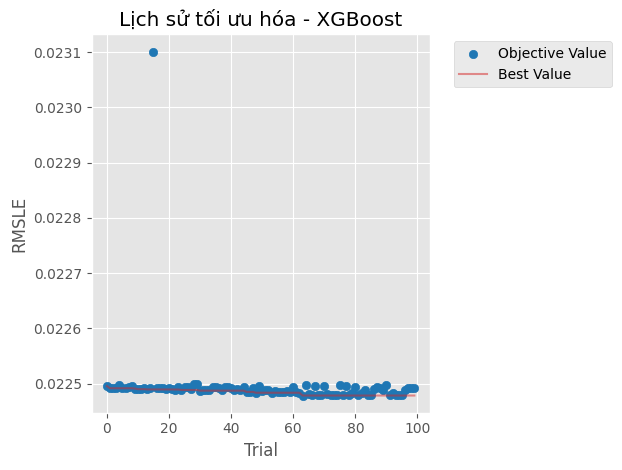

In [193]:
optuna_vis.plot_optimization_history(study_xgb)
plt.title("Lịch sử tối ưu hóa - XGBoost")
plt.xlabel("Trial")
plt.ylabel("RMSLE")
plt.tight_layout()
plt.show()

In [194]:
# === Dữ liệu test ===
y_pred_test = evaluate_model(xgb_model_optuna_v2, X_test, y_test)

📊 Đánh giá mô hình:
RMSLE: 0.0387
RMSE: 0.0444
R²: -0.0064
MAE: 0.0196
Mean target: 0.0268
MAE / mean target: 73.34%


## LightGBM

In [195]:
# ========= Tối ưu với Optuna (theo RMSE) =========
def objective_lgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }

    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(X_train, y_train)

    y_pred = lgb_model.predict(X_val)
    y_true = y_val

    # ✅ Sửa: Tính RMSLE thay vì RMSE
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
    return rmsle
# ========= Tối ưu hóa =========
study_lgb = optuna.create_study(direction='minimize', study_name="LightGBM_RMSLE_v2")
study_lgb.optimize(objective_lgb, n_trials=100)

# ========= Kết quả =========
lgb_best_params_v2 = study_lgb.best_trial.params
print("✅ Best params (LightGBM, RMSLE):", lgb_best_params_v2)

# ========= Lưu các siêu tham số tốt nhất vào file JSON =========
os.makedirs("model_version_2", exist_ok=True)
params_path = "./model_version_2/lgb_best_params_v2.json"
with open(params_path, 'w') as f:
    json.dump(lgb_best_params_v2, f, indent=4)
print(f"✅ Đã lưu siêu tham số tại {params_path}")

# ========= Huấn luyện lại trên toàn bộ train_full_df =========

lgb_model_optuna_v2 = LGBMRegressor(**lgb_best_params_v2, random_state=42)
lgb_model_optuna_v2.fit(X_full, y_full)

# ========= Lưu lại =========
model_path = "./model_version_2/lgb_model_optuna_v2.pkl"
joblib.dump(lgb_model_optuna_v2, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")

[I 2025-08-22 17:18:00,370] A new study created in memory with name: LightGBM_RMSLE_v2
[I 2025-08-22 17:18:00,823] Trial 0 finished with value: 0.022235611425121773 and parameters: {'learning_rate': 0.055113186856328746, 'n_estimators': 200, 'max_depth': 5, 'num_leaves': 22, 'min_child_samples': 39, 'subsample': 0.9455903910278912, 'colsample_bytree': 0.84122289369994, 'reg_alpha': 0.14714778886427105, 'reg_lambda': 0.01687873846509601}. Best is trial 0 with value: 0.022235611425121773.
[I 2025-08-22 17:18:01,227] Trial 1 finished with value: 0.021945757695749593 and parameters: {'learning_rate': 0.06403450177369378, 'n_estimators': 100, 'max_depth': 7, 'num_leaves': 90, 'min_child_samples': 87, 'subsample': 0.7909708052705335, 'colsample_bytree': 0.7532798399846011, 'reg_alpha': 0.025448970868012562, 'reg_lambda': 0.008008840571541588}. Best is trial 1 with value: 0.021945757695749593.
[I 2025-08-22 17:18:01,490] Trial 2 finished with value: 0.022627498396720954 and parameters: {'lear

✅ Best params (LightGBM, RMSLE): {'learning_rate': 0.016594654378272213, 'n_estimators': 300, 'max_depth': 9, 'num_leaves': 62, 'min_child_samples': 91, 'subsample': 0.8183437071727916, 'colsample_bytree': 0.9409177405729834, 'reg_alpha': 0.010806606418210915, 'reg_lambda': 0.06762120090707914}
✅ Đã lưu siêu tham số tại ./model_version_2/lgb_best_params_v2.json
✅ Đã lưu mô hình tại ./model_version_2/lgb_model_optuna_v2.pkl


/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_36863/4172410820.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_lgb)


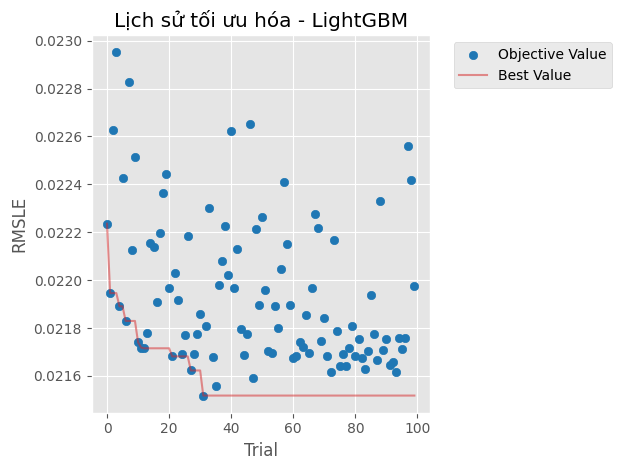

In [196]:
optuna_vis.plot_optimization_history(study_lgb)
plt.title("Lịch sử tối ưu hóa - LightGBM")
plt.xlabel("Trial")
plt.ylabel("RMSLE")
plt.tight_layout()
plt.show()

In [197]:
# === Dữ liệu test ===
y_pred_test = evaluate_model(lgb_model_optuna_v2, X_test, y_test)

📊 Đánh giá mô hình:
RMSLE: 0.0392
RMSE: 0.0449
R²: -0.0306
MAE: 0.0199
Mean target: 0.0268
MAE / mean target: 74.31%


## Catboost

In [208]:
# ========= Tối ưu với Optuna =========
def objective_cat(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08),
        'depth': trial.suggest_int('depth', 3, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'iterations': trial.suggest_int('iterations', 200, 600, step=100),
        'random_strength': trial.suggest_float('random_strength', 0.5, 5.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'loss_function': 'RMSE', # ✅ Tối ưu trực tiếp cho RMSLE
        'verbose': 0,
        'random_seed': 42
    }

    cat_model = CatBoostRegressor(**params)
    cat_model.fit(X_train, y_train)

    y_pred = cat_model.predict(X_val)
    y_true = y_val

    # ✅ Sửa: Tính RMSLE thay vì RMSE
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))
    return rmsle

# ========= Tối ưu hóa =========
study_cat = optuna.create_study(direction='minimize', study_name="CatBoost_RMSLE_v2")
study_cat.optimize(objective_cat, n_trials=100)

# ========= Kết quả =========
cat_best_params_v2 = study_cat.best_trial.params
print("✅ Best params (CatBoost, RMSLE):", cat_best_params_v2)

# ========= Lưu các siêu tham số tốt nhất vào file JSON =========
os.makedirs("model_version_2", exist_ok=True)
params_path = "./model_version_2/cat_best_params_v2.json"
with open(params_path, 'w') as f:
    json.dump(cat_best_params_v2, f, indent=4)
print(f"✅ Đã lưu siêu tham số tại {params_path}")

# ========= Huấn luyện lại trên toàn bộ train_full_df =========

cat_model_optuna_v2 = CatBoostRegressor(**cat_best_params_v2, random_state=42) # ✅ Thêm random_state
cat_model_optuna_v2.fit(X_full, y_full)

# ========= Lưu lại =========
model_path = "./model_version_2/cat_model_optuna_v2.pkl"
joblib.dump(cat_model_optuna_v2, model_path)
print(f"✅ Đã lưu mô hình tại {model_path}")

[I 2025-08-22 17:26:06,094] A new study created in memory with name: CatBoost_RMSLE_v2
[I 2025-08-22 17:26:06,976] Trial 0 finished with value: 0.023545187412441895 and parameters: {'learning_rate': 0.03808169618609837, 'depth': 8, 'l2_leaf_reg': 4.267400301167388, 'iterations': 400, 'random_strength': 4.055306610949032, 'bagging_temperature': 0.5044323703255277, 'border_count': 43}. Best is trial 0 with value: 0.023545187412441895.
[I 2025-08-22 17:26:07,207] Trial 1 finished with value: 0.022382373116017824 and parameters: {'learning_rate': 0.05436139922266235, 'depth': 3, 'l2_leaf_reg': 9.881287459883838, 'iterations': 500, 'random_strength': 0.545370449224639, 'bagging_temperature': 0.47478466684086795, 'border_count': 33}. Best is trial 1 with value: 0.022382373116017824.
[I 2025-08-22 17:26:07,818] Trial 2 finished with value: 0.022965616639473968 and parameters: {'learning_rate': 0.027862545480040433, 'depth': 8, 'l2_leaf_reg': 4.696436831486443, 'iterations': 200, 'random_stren

✅ Best params (CatBoost, RMSLE): {'learning_rate': 0.013088769497207534, 'depth': 4, 'l2_leaf_reg': 6.922650575329226, 'iterations': 200, 'random_strength': 4.407655582961442, 'bagging_temperature': 0.9493801325752771, 'border_count': 63}
✅ Đã lưu siêu tham số tại ./model_version_2/cat_best_params_v2.json
0:	learn: 0.0209747	total: 605us	remaining: 120ms
1:	learn: 0.0209533	total: 1.1ms	remaining: 109ms
2:	learn: 0.0209476	total: 1.71ms	remaining: 112ms
3:	learn: 0.0209278	total: 2.25ms	remaining: 110ms
4:	learn: 0.0209045	total: 2.79ms	remaining: 109ms
5:	learn: 0.0208904	total: 3.39ms	remaining: 110ms
6:	learn: 0.0208741	total: 4.25ms	remaining: 117ms
7:	learn: 0.0208671	total: 5.11ms	remaining: 123ms
8:	learn: 0.0208589	total: 5.62ms	remaining: 119ms
9:	learn: 0.0208347	total: 6.21ms	remaining: 118ms
10:	learn: 0.0208099	total: 6.82ms	remaining: 117ms
11:	learn: 0.0207927	total: 7.32ms	remaining: 115ms
12:	learn: 0.0207851	total: 8.15ms	remaining: 117ms
13:	learn: 0.0207768	total: 9

/var/folders/f4/d5mj2tt90077gj15fqf69fmw0000gn/T/ipykernel_36863/1766385625.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_vis.plot_optimization_history(study_cat)


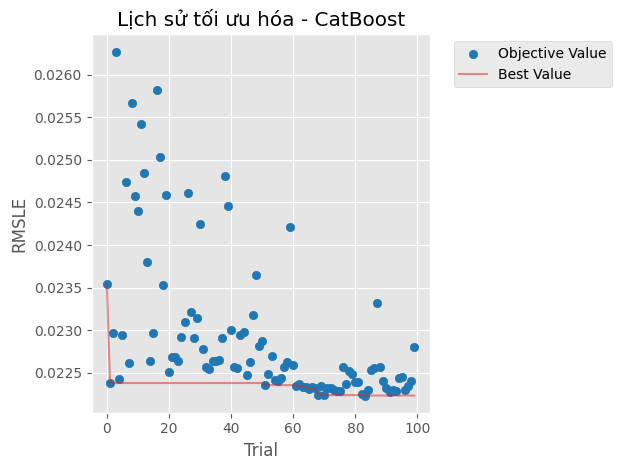

In [209]:
optuna_vis.plot_optimization_history(study_cat)
plt.title("Lịch sử tối ưu hóa - CatBoost")
plt.xlabel("Trial")
plt.ylabel("RMSLE")
plt.tight_layout()
plt.show()

In [235]:
# === Dữ liệu test ===
y_pred_test = evaluate_model(cat_model_optuna_v2, X_test, y_test)

y_test:  0     0.017258
1     0.012579
2     0.024808
3     0.015782
4     0.009111
5     0.004281
6     0.005564
7     0.014736
8     0.015141
9     0.045345
10    0.007617
11    0.113741
12    0.004369
13    0.001405
14    0.359891
15    0.042947
16    0.025158
17    0.020560
18    0.004995
19    0.056007
20    0.004521
21    0.023430
22    0.027428
23    0.073942
24    0.022005
25    0.007220
26    0.021435
27    0.011885
28    0.012821
29    0.012326
30    0.008108
31    0.017860
32    0.003558
33    0.003313
34    0.047850
35    0.008077
36    0.038183
37    0.016217
38    0.001249
39    0.007850
40    0.057283
41    0.058264
42    0.030254
43    0.017851
44    0.015880
45    0.001025
46    0.011373
47    0.011040
48    0.031225
49    0.021550
50    0.022024
51    0.089351
52    0.037679
53    0.044190
54    0.021275
55    0.028812
56    0.026890
57    0.017836
58    0.012363
59    0.008314
60    0.030969
61    0.008534
62    0.070947
63    0.007254
64    0.013454
65    0.009208
6

---

# Linear Model

## Đa cộng tuyến

In [266]:
X = X_full.copy()

# ---- Tính VIF ----
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                              Feature        VIF
0                       evening_nonpr   7.405061
1                    is_weekend_nonpr  15.211298
2                         month_start   4.548989
3   word_count_no_emoji_hashtag_nonpr   9.611786
4      word_count_no_emoji_hashtag_pr   6.509409
5                        playCount_pr   9.599703
6            pr_engagement_rate_input   3.267430
7                     collectCount_pr   4.899642
8                           month_end   3.889968
9                    shareCount_nonpr   2.747770
10                   hashtag_count_pr   6.162569
11                  emoji_count_nonpr   5.510528
12                 collectCount_nonpr   5.486680
13                early_morning_nonpr   1.763307
14                      morning_nonpr   3.369482
15                     duration_nonpr   8.615900
16                      shareCount_pr   5.176311
17                       diggCount_pr  18.998489
18                    diggCount_nonpr   5.798171
19                  

In [211]:
def save_model(model, filename, folder="model_version_2"):
    os.makedirs(folder, exist_ok=True)
    model_path = os.path.join(folder, filename)
    joblib.dump(model, model_path)
    print(f"✅ Đã lưu mô hình tại {model_path}")

In [217]:
def evaluate_model_log_target(model, X_test, y_test):
    # Dự đoán trên thang đo log
    y_pred_log = model.predict(X_test)
    
    # Đảo log để so sánh với y_test ở thang đo gốc
    y_pred = np.expm1(y_pred_log)
    
    # Tính toán các chỉ số
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mean_target = y_test.mean()
    
    print("📊 Đánh giá mô hình:")
    print(f"RMSLE: {rmsle:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Mean target: {mean_target:.4f}")
    print(f"MAE / mean target: {mae / mean_target:.2%}")
    
    return y_pred

## Linear Regression

In [212]:
final_features

['evening_nonpr',
 'is_weekend_nonpr',
 'month_start',
 'female_percent',
 'word_count_no_emoji_hashtag_nonpr',
 'word_count_no_emoji_hashtag_pr',
 'playCount_pr',
 'pr_engagement_rate_input',
 'collectCount_pr',
 'month_end',
 'shareCount_nonpr',
 'hashtag_count_pr',
 'emoji_count_nonpr',
 'collectCount_nonpr',
 'early_morning_nonpr',
 'morning_nonpr',
 'duration_nonpr',
 'shareCount_pr',
 'diggCount_pr',
 'diggCount_nonpr',
 'commentCount_pr']

### áp dụng log transform

In [226]:
y_train_log = np.log1p(train_local_df['EngagementRateOnPRPost_target'])
y_val_log = np.log1p(dev_df['EngagementRateOnPRPost_target'])
y_full_log = np.log1p(train_full_df['EngagementRateOnPRPost_target'])

In [227]:
X_full.describe()

,evening_nonpr,is_weekend_nonpr,month_start,word_count_no_emoji_hashtag_nonpr,word_count_no_emoji_hashtag_pr,playCount_pr,pr_engagement_rate_input,collectCount_pr,month_end,shareCount_nonpr,hashtag_count_pr,emoji_count_nonpr,collectCount_nonpr,early_morning_nonpr,morning_nonpr,duration_nonpr,shareCount_pr,diggCount_pr,diggCount_nonpr,commentCount_pr
count,597.000000,597.000000,597.000000,597.000000,597.000000,5.970000e+02,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,5.970000e+02,5.970000e+02,597.000000
mean,18.909548,10.792295,6.629816,530.110553,198.169179,1.355787e+07,0.019355,17354.442211,6.458961,23006.353434,62.309883,30.385260,67260.755444,0.728643,5.567839,2481.591290,5680.924623,2.433252e+05,1.185540e+06,2888.418760
std,12.216113,6.874015,3.426405,379.089422,285.657666,1.966425e+07,0.014725,36462.891097,3.454460,36183.040909,81.508077,29.189999,100082.304500,1.882470,6.545979,1867.058623,15378.399153,4.856201e+05,1.880133e+06,7630.453254
min,0.000000,0.000000,1.000000,11.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,5.000000,0.000000,0.000000,34.000000,0.000000,0.000000,25.000000,0.000000,0.000000e+00,6.360000e+02,0.000000
25%,10.000000,6.000000,4.000000,273.000000,49.000000,2.258600e+06,0.007969,1618.000000,3.000000,3359.000000,13.000000,9.000000,10178.000000,0.000000,1.000000,1228.000000,449.000000,3.148600e+04,1.730820e+05,232.000000
50%,18.000000,10.000000,7.000000,426.000000,109.000000,6.375700e+06,0.015812,5261.000000,7.000000,11157.000000,35.000000,23.000000,31543.000000,0.000000,3.000000,2006.000000,1499.000000,8.611700e+04,4.623410e+05,702.000000
75%,26.000000,15.000000,10.000000,717.000000,238.000000,1.667100e+07,0.027463,16159.000000,9.000000,27761.000000,84.000000,43.000000,77627.000000,1.000000,9.000000,3363.000000,3628.000000,2.029690e+05,1.370573e+06,1725.000000
max,66.000000,34.000000,12.000000,2068.000000,2295.000000,1.317000e+08,0.123871,314380.000000,12.000000,350100.000000,664.000000,203.000000,940842.000000,14.000000,45.000000,12899.000000,230156.000000,4.143000e+06,1.341619e+07,69571.000000


In [221]:
# ==== Pipeline: StandardScaler + PCA + Linear Regression ====
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),  # giữ 95% phương sai
    ("lr", LinearRegression())
])

# ✅ Huấn luyện trên y_full_log
pipeline_lr.fit(X_full, y_full_log)

print("🔹 Linear Regression")
# ✅ Sử dụng hàm đánh giá mới
_ = evaluate_model_log_target(pipeline_lr, X_test, y_test)

🔹 Linear Regression
📊 Đánh giá mô hình:
RMSLE: 0.0394
RMSE: 0.0450
R²: -0.0341
MAE: 0.0198
Mean target: 0.0268
MAE / mean target: 73.89%


## Ridge

In [228]:
def objective_ridge(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("ridge", Ridge(alpha=alpha, random_state=42))
    ])
    # ✅ Huấn luyện trên dữ liệu đã log-transform
    pipeline.fit(X_train, y_train_log)
    y_pred_log = pipeline.predict(X_val)
    
    # ✅ Tính RMSLE bằng cách so sánh hai giá trị đã log-transform
    rmsle = np.sqrt(mean_squared_error(y_val_log, y_pred_log))
    return rmsle

study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=100)

best_alpha_ridge = study_ridge.best_params['alpha']
pipeline_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("ridge", Ridge(alpha=best_alpha_ridge, random_state=42))
])
# ✅ Huấn luyện lại trên toàn bộ dữ liệu đã log-transform
pipeline_ridge.fit(X_full, y_full_log)

# ✅ Lưu mô hình
# save_model(pipeline_ridge, "ridge_model_optuna.pkl")

print("🔹 Ridge Regression")
# ✅ Sử dụng hàm đánh giá đã được tạo sẵn
_ = evaluate_model_log_target(pipeline_ridge, X_test, y_test)

[I 2025-08-22 18:04:07,281] A new study created in memory with name: no-name-e2c8c9e7-6049-4570-b8f7-cef85c958fd1
[I 2025-08-22 18:04:07,552] Trial 0 finished with value: 0.02173511943500007 and parameters: {'alpha': 0.0018602797151271633}. Best is trial 0 with value: 0.02173511943500007.
[I 2025-08-22 18:04:07,577] Trial 1 finished with value: 0.021734361861726316 and parameters: {'alpha': 0.3110466039452071}. Best is trial 1 with value: 0.021734361861726316.
[I 2025-08-22 18:04:07,595] Trial 2 finished with value: 0.021733410991385156 and parameters: {'alpha': 0.7012551747206922}. Best is trial 2 with value: 0.021733410991385156.
[I 2025-08-22 18:04:07,612] Trial 3 finished with value: 0.021735114468864763 and parameters: {'alpha': 0.003882220707470524}. Best is trial 2 with value: 0.021733410991385156.
[I 2025-08-22 18:04:07,645] Trial 4 finished with value: 0.021733281892672617 and parameters: {'alpha': 0.7544177074307999}. Best is trial 4 with value: 0.021733281892672617.
[I 2025-

🔹 Ridge Regression
📊 Đánh giá mô hình:
RMSLE: 0.0393
RMSE: 0.0450
R²: -0.0331
MAE: 0.0198
Mean target: 0.0268
MAE / mean target: 73.81%


## Lasso Regression

In [229]:
# ========= Tối ưu với Optuna (trên RMSLE) =========
def objective_lasso(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1.0, log=True)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("lasso", Lasso(alpha=alpha, max_iter=10000, random_state=42))
    ])
    # ✅ Huấn luyện trên dữ liệu đã log-transform
    pipeline.fit(X_train, y_train_log)
    y_pred_log = pipeline.predict(X_val)
    
    # ✅ Tính RMSLE bằng cách so sánh hai giá trị đã log-transform
    rmsle = np.sqrt(mean_squared_error(y_val_log, y_pred_log))
    return rmsle

study_lasso = optuna.create_study(direction='minimize')
study_lasso.optimize(objective_lasso, n_trials=100)

best_alpha_lasso = study_lasso.best_params['alpha']
pipeline_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("lasso", Lasso(alpha=best_alpha_lasso, max_iter=10000, random_state=42))
])
# ✅ Huấn luyện lại trên toàn bộ dữ liệu đã log-transform
pipeline_lasso.fit(X_full, y_full_log)

# ✅ Lưu mô hình
save_model(pipeline_lasso, "lasso_model_optuna.pkl")

print("🔹 Lasso Regression")
# ✅ Sử dụng hàm đánh giá đã được tạo sẵn
_ = evaluate_model_log_target(pipeline_lasso, X_test, y_test)

[I 2025-08-22 18:11:22,848] A new study created in memory with name: no-name-3c7b835f-d15c-4455-bc7b-4285fd4f172d
[I 2025-08-22 18:11:23,037] Trial 0 finished with value: 0.022505521109762443 and parameters: {'alpha': 0.1735550292115238}. Best is trial 0 with value: 0.022505521109762443.
[I 2025-08-22 18:11:23,054] Trial 1 finished with value: 0.021754315283606985 and parameters: {'alpha': 0.00015154627511432882}. Best is trial 1 with value: 0.021754315283606985.
[I 2025-08-22 18:11:23,067] Trial 2 finished with value: 0.022505521109762443 and parameters: {'alpha': 0.1155094508384959}. Best is trial 1 with value: 0.021754315283606985.
[I 2025-08-22 18:11:23,076] Trial 3 finished with value: 0.022472149833146025 and parameters: {'alpha': 0.005343232358201029}. Best is trial 1 with value: 0.021754315283606985.
[I 2025-08-22 18:11:23,090] Trial 4 finished with value: 0.022505521109762443 and parameters: {'alpha': 0.06264081430620559}. Best is trial 1 with value: 0.021754315283606985.
[I 2

✅ Đã lưu mô hình tại model_version_2/lasso_model_optuna.pkl
🔹 Lasso Regression
📊 Đánh giá mô hình:
RMSLE: 0.0393
RMSE: 0.0449
R²: -0.0315
MAE: 0.0197
Mean target: 0.0268
MAE / mean target: 73.58%


## SVR

In [230]:
# ========= Tối ưu với Optuna (trên RMSLE) =========
def objective_svr(trial):
    C = trial.suggest_float("C", 0.1, 100.0, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-4, 0.1, log=True)
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("svr", SVR(kernel='rbf', C=C, epsilon=epsilon))
    ])
    # ✅ Huấn luyện trên dữ liệu đã log-transform
    pipeline.fit(X_train, y_train_log)
    y_pred_log = pipeline.predict(X_val)
    
    # ✅ Tính RMSLE bằng cách so sánh hai giá trị đã log-transform
    rmsle = np.sqrt(mean_squared_error(y_val_log, y_pred_log))
    return rmsle

study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=100)

best_params_svr = study_svr.best_params
pipeline_svr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("svr", SVR(kernel='rbf', C=best_params_svr["C"], epsilon=best_params_svr["epsilon"]))
])
# ✅ Huấn luyện lại trên toàn bộ dữ liệu đã log-transform
pipeline_svr.fit(X_full, y_full_log)

# ✅ Lưu mô hình
save_model(pipeline_svr, "svr_model_optuna.pkl")

print("🔹 SVR")
# ✅ Sử dụng hàm đánh giá đã được tạo sẵn
_ = evaluate_model_log_target(pipeline_svr, X_test, y_test)

[I 2025-08-22 18:12:31,855] A new study created in memory with name: no-name-29f795a0-31f2-4a68-b180-41d14e97e520
[I 2025-08-22 18:12:32,558] Trial 0 finished with value: 0.028624223577413153 and parameters: {'C': 13.549378475728439, 'epsilon': 0.000413541031609482}. Best is trial 0 with value: 0.028624223577413153.
[I 2025-08-22 18:12:32,569] Trial 1 finished with value: 0.04269413334765738 and parameters: {'C': 1.0835981005554451, 'epsilon': 0.08185657793734255}. Best is trial 0 with value: 0.028624223577413153.
[I 2025-08-22 18:12:32,623] Trial 2 finished with value: 0.019698862278973515 and parameters: {'C': 0.6873075411150934, 'epsilon': 0.0078608696823629}. Best is trial 2 with value: 0.019698862278973515.
[I 2025-08-22 18:12:32,772] Trial 3 finished with value: 0.032300105023491885 and parameters: {'C': 41.57402251845356, 'epsilon': 0.008999027880479552}. Best is trial 2 with value: 0.019698862278973515.
[I 2025-08-22 18:12:32,968] Trial 4 finished with value: 0.0264964056741689

✅ Đã lưu mô hình tại model_version_2/svr_model_optuna.pkl
🔹 SVR
📊 Đánh giá mô hình:
RMSLE: 0.0396
RMSE: 0.0453
R²: -0.0490
MAE: 0.0203
Mean target: 0.0268
MAE / mean target: 75.86%
